In [1]:
'''
Run the partial sports field registration
1. extract lines and determine vanishing points for each frame
2. find all pairs of potential camera calibrations for these VPs that are consistent with the image lanes
'''
None

In [2]:
import os
from PIL import Image

import sys
sys.path.append('../src')

from unreal_util import *
from projection_util import *
from mappings import *
from hough_util import *

# data settings - adapt for location and sequence you pick
data_root = '/disk2/data/UE5sim_3DHPE/'
exp = 'ath0_run'

data_path = os.path.join(data_root, exp)
img_fold = os.path.join(data_path, 'MovieRenders')
img_pattern = os.path.join(img_fold, exp + '.%04d.jpeg')
hough_file = os.path.join(data_path, 'hough_results.pkl')

groundtruth = pickle.load(open(os.path.join(data_path, 'groundtruth.pkl'), 'rb'))
N = len(groundtruth) - 1
print('img_folder:', img_fold)
print('#frames:', N)

img_folder: /disk2/data/UE5sim_3DHPE/ath0_run/MovieRenders
#frames: 341


In [3]:
# collect all imgs
vid_array = []
for frame in tqdm(range(N)):
    img_path = img_pattern%frame
    if not os.path.exists(img_path):
        print('MISSING', img_path)
        continue
    img = np.array(Image.open(img_path).convert('RGB'))
    vid_array.append(img)

100%|██████████| 341/341 [00:06<00:00, 56.56it/s]


## 1. find lines and vanishing points

In [4]:
# determine vanishing points
from hough_util import *

if not os.path.exists(hough_file):
    imgs = []
    frame_to_vanish_all = {}
    proto_segs = {}
    frame_to_hough_dict = {}

    hough_arg_dict = {}
    plot_it = False
    for i in tqdm(range(N)):
        img = vid_array[i].copy()
        plines, nplines = get_lines_for_img(img, arg_dict=hough_arg_dict)
        frame_to_hough_dict[i] = plines

        proto_segments = get_main_segments_from_lines(plines[:, 0, :])
        for k, p in enumerate(proto_segments):
            proto_segments[k] = seg_to_full_width(img, p)

        proto_seg = proto_segments.astype(int)[:, np.newaxis, :]
        v0, v1 = determine_vanish_points(proto_seg, nplines)
        frame_to_vanish_all[i] = [v0, v1]

        img = draw_lines_on_img(img, proto_seg, nplines)
        midline = proto_seg[len(proto_seg)//2, 0, :]

        proto_segs[i] = proto_seg

        if plot_it:
            print(v0)
            plt.scatter(*v0)
            plt.imshow(img)
            plt.xlim(-3000, 1300)
            plt.ylim(800, -800)
            break

        imgs.append(img)
    store_dict = {'vanish': frame_to_vanish_all, 'proto': proto_segs, 'plines': frame_to_hough_dict}
    pickle.dump(store_dict, open(hough_file, 'wb'))
else:
    store_dict = pickle.load(open(hough_file, 'rb'))
    frame_to_vanish_all = store_dict['vanish']
    proto_segs = store_dict['proto']
    frame_to_hough_dict = store_dict['plines']
    
frame_to_proto_seg_to_id, frame_lane_id_to_proto_id = track_lanes(proto_segs)

In [5]:
# get the groundtruth vanishing points!

img = vid_array[0]

plot_it = False

gt_v0s = {}
gt_protosegs = {}
gt_frame_lane_id_to_proto_id = {}
for frame in range(N):
    # 1. get params and project
    params = groundtruth[frame]['projection']
    lanes2d = project_lines(params, lanes_new[1])

    # 2. crop to protosegs
    ps = []
    for l in lanes2d[::2]:
        l2 = seg_to_full_width(img, l)
        ps.append(l2.reshape(2,2))
    ps = np.array(ps)

    # 3. determine the v0 and store
    v0 = get_median_vanish(ps[:, np.newaxis])
    gt_protosegs[frame] = ps.reshape(-1, 4)[:, np.newaxis]
    gt_v0s[frame] = [v0, None]
    gt_frame_lane_id_to_proto_id[frame] = {i:i for i in range(len(ps))}

    if plot_it:
        plt.figure(figsize=(15,10))
        plt.imshow(vid_array[frame])
        for l in ps:
            print(l)
            plt.plot(*l.reshape(2,2).T)
        plt.scatter(*v0)
        break

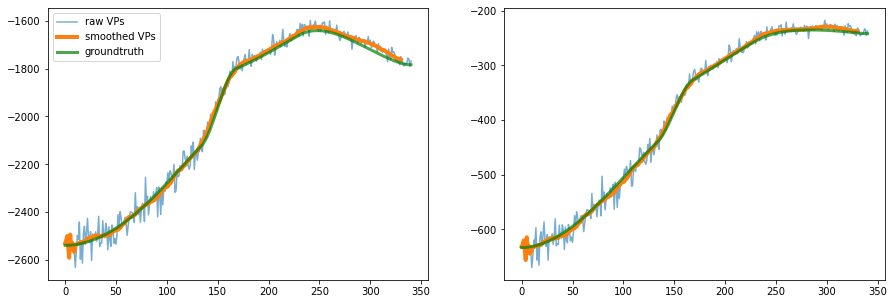

In [6]:
# compare our predicted vanishing points with the actual correct VPs.
# looks fine!

v0s = np.vstack([v[0] for v in frame_to_vanish_all.values()])

fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

window = 20
smooth_together = smooth(v0s, window)

v0x = v0s[:, 0]
v0x_smooth = np.hstack((v0x[:window//2], smooth(v0x, window)))

v0y = v0s[:, 1]
v0y_smooth = np.hstack((v0y[:window//2], smooth(v0y, window)))

axs[0].plot(v0x, label='raw VPs', alpha=.6)
axs[0].plot(v0x_smooth, label='smoothed VPs', linewidth=4)
axs[1].plot(v0y, alpha=.6)
axs[1].plot(v0y_smooth, linewidth=4)

# also smooth using x/y coordinates in cmobination. doesn't really look that much better.
# axs[0].plot(np.arange(len(smooth_together))+window//2, smooth_together[:, 0], color='purple')

gt_v0_arr = np.array([v[0] for k, v in gt_v0s.items()])
axs[0].plot(gt_v0_arr[:, 0], color='green', linewidth=3, alpha=.7, label='groundtruth')
axs[1].plot(gt_v0_arr[:, 1], color='green', linewidth=3, alpha=.7)

axs[0].legend()

frame_to_vanish_all_smooth = {k: [v, None] for k, v in enumerate(zip(v0x_smooth, v0y_smooth))}

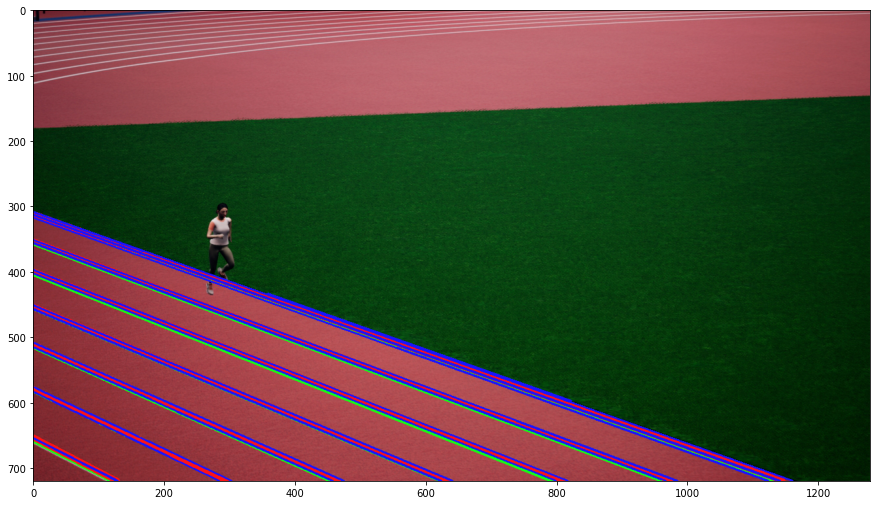

In [7]:
%matplotlib inline
from anim_util import *
# draw img to compare line segment predictions and our the groundtruth lines in the iamge.

frame = 115

img = vid_array[frame].copy()
ps = gt_protosegs[frame]
proto = proto_segs[frame]

for p in ps:
    sp = p[0][:2].astype(int)
    ep = p[0][2:].astype(int)
    cv2.line(img, sp, ep, (20, 255, 20), 8) 

for p in proto:
    sp = p[0][:2].astype(int)
    ep = p[0][2:].astype(int)
    cv2.line(img, sp, ep, (255, 20, 20), 8) 

p_lines = frame_to_hough_dict[frame]
for p in p_lines:
    sp = p[0][:2].astype(int)
    ep = p[0][2:].astype(int)
    cv2.line(img, sp, ep, (25, 20, 255), 2)
    
plt.figure(figsize=(15,10))
plt.imshow(img)

## 2. predict the sports field

In [8]:
# create a lookup grid for azim/elev pairs that could explain the VPs
ranges = {'azim': list(np.arange(-89, -1, 1)),
  'elev': list(np.arange(-25, -1, 1)),
  'dist': [50],
  'fov': [40],#list(np.arange(1, 10, 2)),
  'F': [1]#list(np.arange(1, 10, 2))
 }

no_roll = True

df_lookup = create_look_up_grid(ranges, no_roll)

100%|██████████| 2112/2112 [00:03<00:00, 648.30it/s]


In [9]:
%%writefile _pool_func_azim.py

'''
in notebook generated function to parallelize extraction of azim-pairs for all frames
'''

from projection_util import *

def process_k_(k, df, proto_segs, frame_lane_id_to_proto_id, 
               frame_to_vanish_all, skel_store_dict, ind0=0, ind1=4):
    
    try:
        if not ind1 in frame_lane_id_to_proto_id[k]:
            ind1 = 2
        proto_l0 = proto_segs[k][frame_lane_id_to_proto_id[k][ind0]][0]
        proto_l1 = proto_segs[k][frame_lane_id_to_proto_id[k][ind1]][0]
        v0_ = frame_to_vanish_all[k][0]
        v0 = [v0_[0], -v0_[1] + h]

        az_all = azim_from_v0_proto_no_shift(df, proto_l0, proto_l1, v0, k=k,
                                skel_store_dict=skel_store_dict, proj_indA=ind0, proj_indB=ind1, debug=True)
    except Exception as e:
        return k, None

    return k, az_all

Overwriting _pool_func_azim.py


In [10]:
# perform the search for matching VPs in parallel on 12 cores

import os
from multiprocess import Pool
from importlib import reload
import _pool_func_azim
reload(_pool_func_azim)

azim_file = '%s/azim_pairs.pkl'%data_path

max_pool = 12
N = len(vid_array)

vanish_points = frame_to_vanish_all_smooth

proto_segs_pick = proto_segs
vanish_points = frame_to_vanish_all
frame_lane_id_to_proto_id_pick = frame_lane_id_to_proto_id

with Pool(max_pool) as p:
    pool_outputs = list(
        tqdm(
            p.imap(lambda k: _pool_func_azim.process_k_(k, df_lookup, proto_segs_pick, 
                            frame_lane_id_to_proto_id_pick, vanish_points,
                            {}),
                   range(N)),
            total=N
        )
    )

azim_pairs = dict(pool_outputs)

pickle.dump(azim_pairs, open(azim_file,'wb'))

100%|██████████| 341/341 [01:27<00:00,  3.88it/s]


In [11]:
def trans_fun(x, h=720):
    x_out = x.copy()
    x_out[:, 1] = h - x_out[:, 1]
    return x_out

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(IntSlider(value=10, description='k', max=341, min=1), FloatSlider(value=12.2, descriptio…

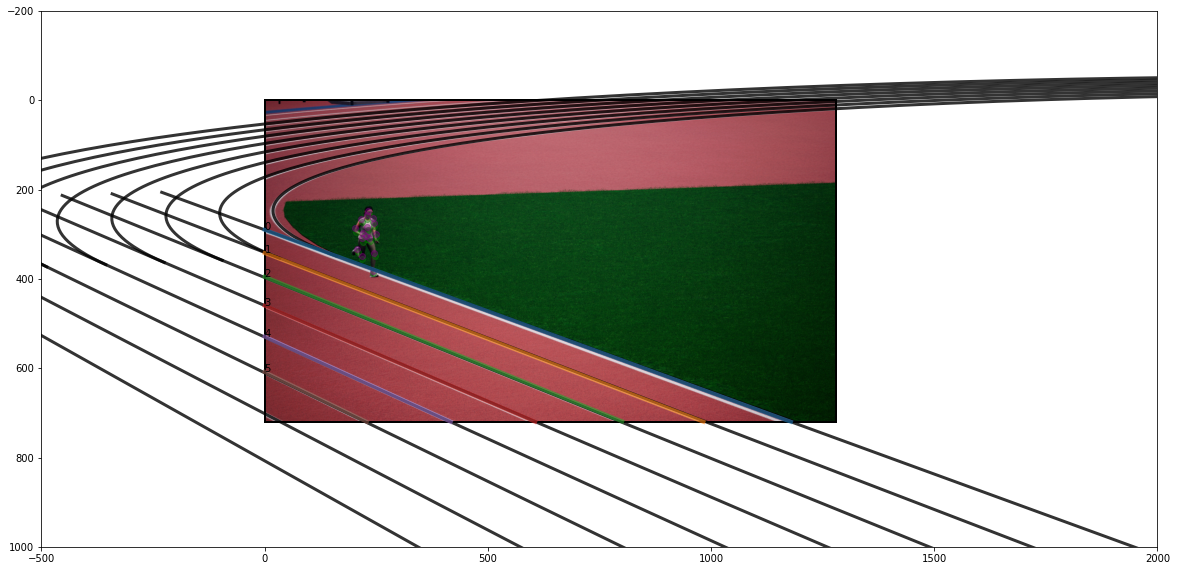

In [12]:
# interactive widget to explore the differnent possible camera parameters. 
# this cell needs to be rerun a couple of times sometimes to enable the full
# functionality o_O

%matplotlib widget
import ipywidgets as widgets

store_camera_params_dict = {}

res_dict = None
plt.figure(figsize=(20, 10))
ax = plt.subplot(111)

@widgets.interact(k=(1, len(frame_to_vanish_all)), cam_id=(0., 50., .1), x_off=(-40., 240.), target_height=(1, 15, .2))
def render_scene(k=10, cam_id=12.2, x_off=-9.4, target_height=9.35, use_height=False):
    ax.clear()
    
    gt2d = groundtruth[k]['2d']
    gt3d = groundtruth[k]['3d']

    image = vid_array[k]
    ax.imshow(image)
       
    if cam_id>=len(azim_pairs[k]['rds']):
        cam_id = len(azim_pairs[k]['rds'])-1
           
    best, cid_best = interpolate_params(azim_pairs[k]['rds'], target_height)
    az_pair = interpolate(azim_pairs[k]['rds'], cam_id)
        
    if use_height:
        print('best cam id', cid_best)
        az_pair = best
            
    # what 3d xshift do we have to perform to move
    rd0 = azim_pairs[k]['rds'][0]
    rd0b = shift_x(rd0, x_off)
    p_start = get_lane1_marker(rd0b)
        
    p_cam = get_lane1_marker(az_pair)
    # the original marker in 3d from the new camera
    p_cam_3d = ray_cast_point(p_start, az_pair['cam_pos'], az_pair['image_plane'], z_off=0)
    p_cam_3db = ray_cast_point(p_cam, az_pair['cam_pos'], az_pair['image_plane'], z_off=0)
            
    # what is the distance to the lane1 marker in 3d from the
    x_off2 = p_cam_3db[0] - p_cam_3d[0]
    res_dict = shift_x(az_pair, x_off2)
    print(x_off, x_off2)
    
    lines2d = res_dict['lines_2ds'].copy()
    
    draw2d(ax, lines2d, res_dict['base_pts'], color='black', trans_fun=trans_fun, linewidth=3, alpha=.8)
    
    gt_proj = project_lines(res_dict, gt3d)
    ax.scatter(*gt2d.T, color='green', alpha=.4)
    ax.scatter(*trans_fun(gt_proj).T, color='purple', alpha=.4)
    
    # also display the protosegs.
    for i, ps in enumerate(proto_segs[k]):
        col = 'black'
        
        if k in frame_to_proto_seg_to_id and i in frame_to_proto_seg_to_id[k]:
            lane_id = frame_to_proto_seg_to_id[k][i]
            if lane_id > 10:
                col = 'purple'
            else:
                col = tab10(lane_id)
        
        ax.plot(*ps[0].reshape(2,2).T, linewidth=4, alpha=.6, color=col)
        ax.text(*ps[0, :2], i)
        
    print('cam_vec', res_dict['cam_pos'])
    print('cam_rot', [res_dict['azim'], res_dict['elev'], res_dict['roll']])
    print('v1', res_dict['v1'])
    
    store_camera_params_dict[k] = {'cam_id': cam_id, 'x_off': x_off}
    
    print(store_camera_params_dict)
        
    ax.set_xlim(-500, 2000)
    ax.set_ylim(1000, -200)